<a href="https://colab.research.google.com/github/arjoca/RHDocentes/blob/testing/RHDocentes_third_draft_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparação

## Fontes de informação

*   Ficheiro "Afetacao_Financeira_ADs_Cursos_2021_v01.xlsx"
*   Ficheiro "RAIDES_0.xlsx" 

Informação que depois de filtrada e anonimizada deu origem aos dados guardados no ficheiro [clean_data.xlsx](https://github.com/arjoca/RHDocentes/blob/main/clean_data.xlsx), usados neste estudo.

## Importação de módulos e leitura de dados

In [ ]:
# instalação de módulos
!pip install squarify

In [ ]:
# importação de módulos
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import squarify
from ipywidgets import widgets, interact, fixed

In [ ]:
# Leitura de dados
base_url = 'https://raw.githubusercontent.com/arjoca/RHDocentes/main/'
docentes = pd.read_csv(base_url + 'docentes.csv', encoding= 'unicode_escape', 
                       parse_dates=['Data Nascimento'], infer_datetime_format=True)
alunos_per_curso = pd.read_csv(base_url + 'alunos.csv', encoding= 'unicode_escape', index_col=0)
horas = pd.read_csv(base_url + 'horas.csv', encoding= 'unicode_escape', index_col=0)

In [ ]:
pd.options.display.float_format = "{:,.1f}".format

## Designações de cenas

In [ ]:
# Designações dos cursos e departamentos
LISTA_DEPTS = docentes['Departamento'].unique()
LISTA_CURSOS = alunos_per_curso.index.unique()

In [ ]:
# Designações das categorias de docentes
cat_prof_coord = ['Prof. Coordenador', 'Prof. Coordenador c/ Agreg. ', 'Professor Coordenador Principal']
cat_convidado = ['Assistente Convidado', 'Professor Adjunto Convidado']
cat_adjunto = ['Professor Adjunto']
cat_assistente = ['Assistente do 2. Trienio', 'Assistente', 'Equiparado Assistente 2. Trienio']
cat_monitor = ['Monitor']
cat_quadro = cat_prof_coord + cat_adjunto
cat_todas = cat_quadro + cat_convidado + cat_assistente + cat_monitor

## Definição de funções

In [ ]:
# Filtragem de docentes atendendo à sua idade de aposentação 
def aposentados_e_ativos(df, ano, idade_reforma):
    idade = (datetime(ano, 1, 1) - df['Data Nascimento'])/timedelta(days=365.25)
    aposentados = df[idade > idade_reforma]
    ativos = df.drop(index=aposentados.index)
    return aposentados, ativos

In [ ]:
# Filtragem de docentes atendendo à sua categoria
def docentes_per_categoria(df, categoria):
  s = df.groupby(['Departamento', 'Categoria'])['ETI'].count()
  s = s.loc[(slice(None), categoria)].droplevel(level=1)
  s = s.groupby(s.index).sum()
  s = pd.Series(s, index=LISTA_DEPTS)
  return s.fillna(0)

In [ ]:
# Prepara dados para visualizar com treemap
def prepare_to_treemap(tabela_horas, dept=None, threshold_percentage=0.01):
  s = tabela_horas[dept].copy() if dept is not None else tabela_horas.sum(axis=1)
  total = s.values.sum()
  threshold = threshold_percentage * total
  s = s[s > threshold]
  remainder = total - s.values.sum()
  s = s.append(pd.Series(data=[remainder], index=['OUTROS']))
  return s.sort_values(ascending=False)

# Exploração de dados

## Elementos constantes (para simplificar)

In [ ]:
# Elementos constantes (time independent features)
# Simplificação: constância do número de alunos e das horas de contacto 
horas_per_dept = horas.sum()
horas_per_curso = horas.sum(axis=1)

pesos_dept_per_curso = horas.T / horas_per_curso
pesos_curso_per_dept = horas / horas_per_dept
alunos_per_dept = pd.DataFrame(np.dot(pesos_dept_per_curso, alunos_per_curso),
                              index=pesos_dept_per_curso.index, columns=['Alunos'])
alunos_per_dept = alunos_per_dept['Alunos']
alunos_per_curso = alunos_per_curso['Alunos']

### Fotografia do ISEL hoje (2022)

#### Eficiência relativa de cada departamento

In [ ]:
# Eficiência relativa dos departamentos/cursos
ratio_aluno_hora_ISEL = alunos_per_curso.sum() / horas_per_curso.sum()
eff_per_dept = 100 * alunos_per_dept / horas_per_dept / ratio_aluno_hora_ISEL
eff_per_curso = 100 * alunos_per_curso / horas_per_curso / ratio_aluno_hora_ISEL
eff_per_curso.dropna(inplace=True)

Text(0.5, 1.0, 'Eficiência relativa de cada departamento')

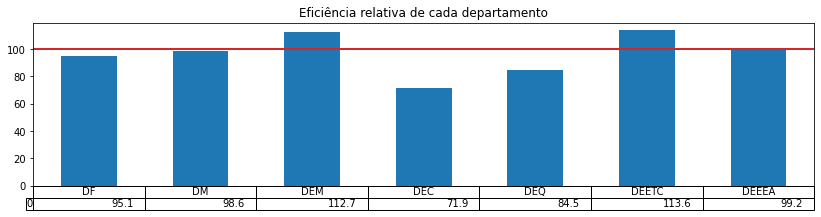

In [ ]:
# Figura com eficiência relativa de cada departamento
fig, ax = plt.subplots(1, 1, figsize=(14,3))
eff_per_dept.plot(kind='bar', table=np.round(eff_per_dept.to_frame().T, 1), ax=ax)
ax.axhline(y=100,linewidth=2, color='#d62728')
ax.xaxis.set_visible(False)
ax.set_title('Eficiência relativa de cada departamento')


#### Eficiência relativa de cada curso

Text(0.5, 1.0, 'Eficiência relativa de cada curso de licenciatura')

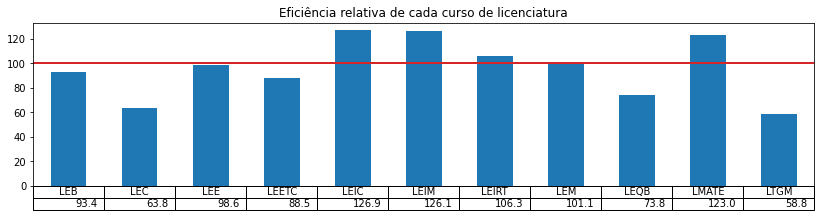

In [ ]:
# Figura com eficiência relativa de cada curso (licenciatura)
eff_per_licenciatura = eff_per_curso[:11]
eff_per_licenciatura.name=''
fig, ax = plt.subplots(1, 1, figsize=(14,3))
eff_per_licenciatura.plot(kind='bar', 
                          table=np.round(eff_per_licenciatura.to_frame().T, 1), ax=ax)
ax.axhline(y=100,linewidth=2, color='#d62728')
ax.xaxis.set_visible(False)
ax.set_title('Eficiência relativa de cada curso de licenciatura')

Text(0.5, 1.0, 'Eficiência relativa de cada curso de mestrado')

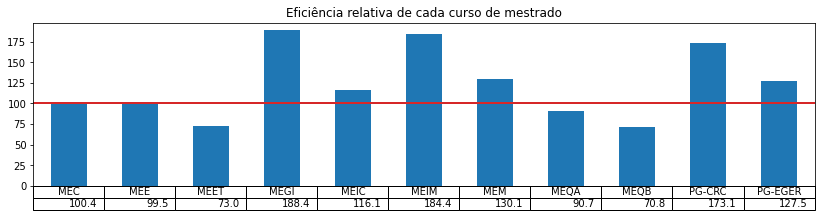

In [ ]:
# Figura com eficiência relativa de cada curso (mestrado)
eff_per_mestrado = eff_per_curso[11:]
eff_per_mestrado.name=''
fig, ax = plt.subplots(1, 1, figsize=(14,3))
eff_per_mestrado.plot(kind='bar', 
                          table=np.round(eff_per_mestrado.to_frame().T, 1), ax=ax)
ax.axhline(y=100,linewidth=2, color='#d62728')
ax.xaxis.set_visible(False)
ax.set_title('Eficiência relativa de cada curso de mestrado')

#### Distribuição das horas por departamento

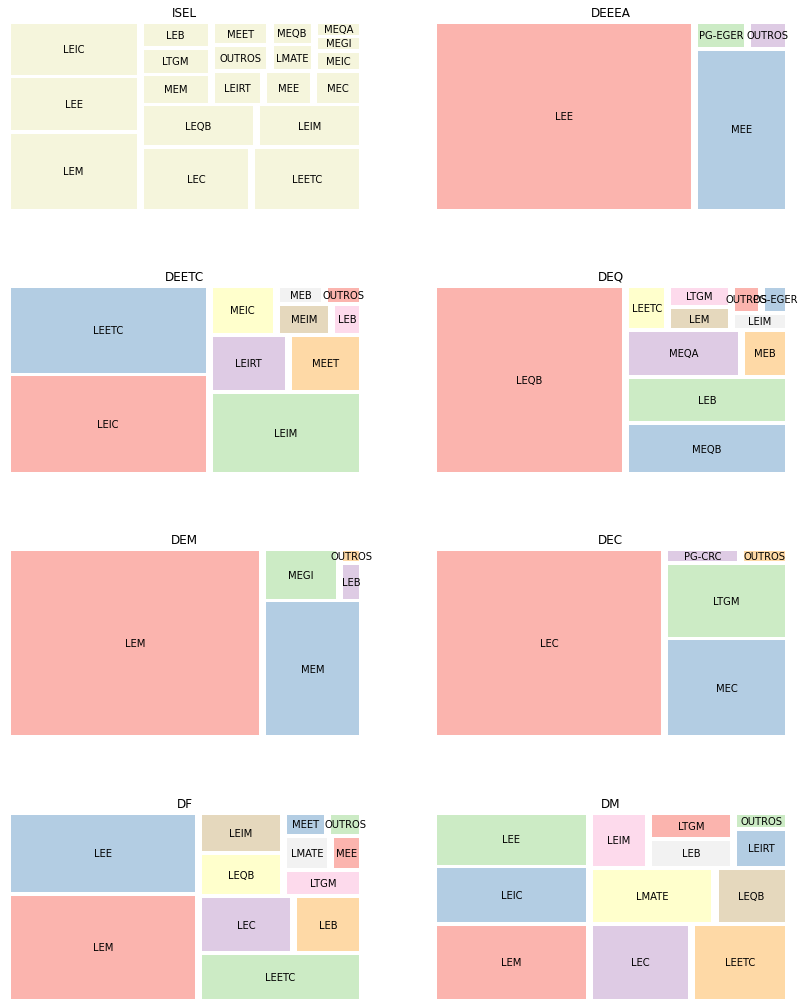

In [ ]:
# Distribuição das horas de contacto em cada departamento
cm = matplotlib.cm.get_cmap('Pastel1')
width = 0.25
plt.figure(figsize=(14, 18))
plt.subplots_adjust(hspace=0.4)

plt.subplot(4, 2, 1)
s = prepare_to_treemap(horas)
squarify.plot(sizes=s.values, label=s.index, pad=True, color='beige')
plt.axis('off')
plt.title('ISEL')

for i, dept in enumerate(LISTA_DEPTS):
  plt.subplot(4, 2, i+2)
  s = prepare_to_treemap(horas, dept)
  squarify.plot(sizes=s.values, label=s.index, pad=True, color=cm.colors)
  plt.axis('off')
  plt.title(dept)

In [ ]:
# Detalhe e interativo
@interact(depart=widgets.Dropdown(options=LISTA_DEPTS, value='DEETC'))
def f(depart):
  s = prepare_to_treemap(horas, depart)
  s.name=''
  squarify.plot(sizes=s.values, label=s.index, pad=True, color=cm.colors)
  print(s.to_frame()/s.values.sum()*100)
  plt.axis('off')

interactive(children=(Dropdown(description='depart', index=1, options=('DEEEA', 'DEETC', 'DEQ', 'DEM', 'DEC', …

## Elementos que variam no tempo

In [ ]:
ANO = 2022
IDADE_REFORMA = 70
aposentados, ativos = aposentados_e_ativos(docentes, ANO, IDADE_REFORMA)

In [ ]:
# Rácio Alunos / ETI
alunos_per_eti_isel = alunos_per_curso.sum() / ativos['ETI'].sum()
eti_per_dept = ativos.groupby(['Departamento'])['ETI'].sum()
alunos_per_eti_dept = alunos_per_dept / eti_per_dept
alunos_per_eti_dept.dropna(inplace=True)

### ETIs por departamento

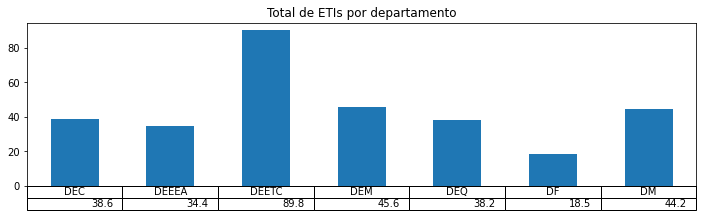

In [ ]:
# Figura com ETI por departamento
fig, ax = plt.subplots(1, 1, figsize=(12,3))
eti_per_dept.name=''
eti_per_dept.plot(kind='bar', ax=ax, 
                  table=np.round(eti_per_dept.to_frame().T, 1))
ax.xaxis.set_visible(False)
ax.set_title('Total de ETIs por departamento');

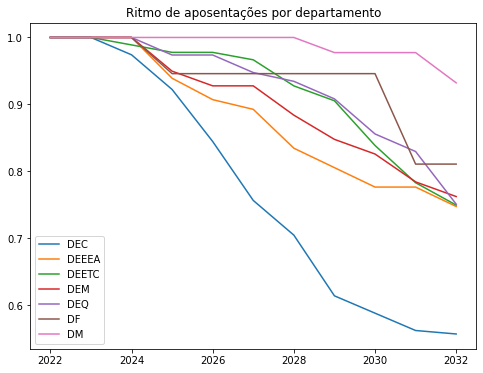

In [ ]:
# Ritmo de aposentações
ano_inicial = 2022
ano_final = ano_inicial + 10
df = pd.DataFrame()
for ano in range(ano_inicial, ano_final+1):
  ap, at = aposentados_e_ativos(docentes, ano, IDADE_REFORMA)
  s = at.groupby(['Departamento'])['ETI'].sum()
  s.name = str(ano)
  df = df.append(s)

percentage = df /df.loc[str(ano_inicial)]
fig, ax = plt.subplots(1, 1, figsize=(8,6))
percentage.plot(ax=ax)
ax.set_title('Ritmo de aposentações por departamento');

### Rácio Alunos por ETI

Text(0.5, 1.0, 'Alunos / ETI')

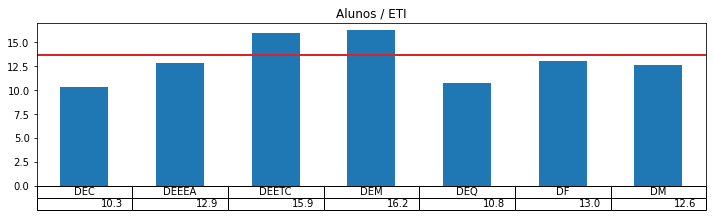

In [ ]:
# Figura com rácio Alunos/ETI por departamento
fig, ax = plt.subplots(1, 1, figsize=(12,3))
alunos_per_eti_dept.name='' 
alunos_per_eti_dept.plot(kind='bar', 
                          table=np.round(alunos_per_eti_dept.to_frame().T, 1), ax=ax)
ax.axhline(y=alunos_per_eti_isel,linewidth=2, color='#d62728')
ax.xaxis.set_visible(False)
ax.set_title('Alunos / ETI')

### ETIs em falta



In [ ]:
# VIANA (Valor Ideal Atendendo ao Número de Alunos)
alunos_per_eti_ideal = alunos_per_eti_isel
viana = alunos_per_dept / alunos_per_eti_ideal
fana = viana - eti_per_dept

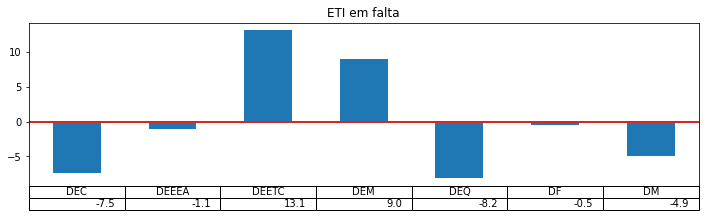

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,3))
fana.name='' 
fana.plot(kind='bar', table=np.round(fana.to_frame().T, 1), ax=ax)
ax.xaxis.set_visible(False)
ax.axhline(y=0,linewidth=2, color='#d62728')
ax.set_title('ETI em falta');

### Docentes por categoria

In [ ]:
# Ritmo de aposentações na categoria
ano_inicial = 2022
ano_final = ano_inicial + 10
catgs = {'Coordenadores':cat_prof_coord, 
         'Adjuntos': cat_adjunto,
         'Quadro': cat_quadro,
         'Convidados': cat_convidado,
         'Todas': cat_todas}
@interact(categoria=widgets.Dropdown(options=catgs, value=cat_prof_coord))
def f(categoria):
  df = pd.DataFrame()
  for ano in range(ano_inicial, ano_final+1):
    ap, at = aposentados_e_ativos(docentes, ano, IDADE_REFORMA)
    s = docentes_per_categoria(at, categoria)
    s.name = str(ano)
    df = df.append(s)

  percentage = df /df.loc[str(ano_inicial)]
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))
  percentage.plot(ax=ax)
  ax.set_title('Ritmo de aposentações na categoria por departamento');

interactive(children=(Dropdown(description='categoria', options={'Coordenadores': ['Prof. Coordenador', 'Prof.…

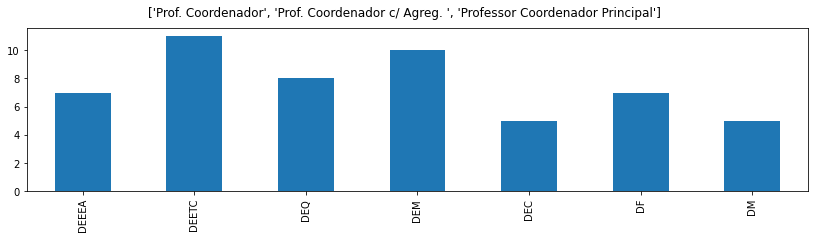

In [ ]:
plt.figure(1, figsize=(14, 3))
docentes_per_categoria(ativos, cat_prof_coord).plot.bar()
plt.suptitle(f'{cat_prof_coord}');

# Equalização de recursos docentes

## Definir o rácio que se pretende uniformizar

In [ ]:
ratio_numerator = docentes_per_categoria(ativos, cat_prof_coord)

In [ ]:
ratio_denominator_1 = docentes_per_categoria(ativos, cat_quadro)
ratio_denominator_2 = docentes_per_categoria(ativos, cat_quadro) + \
          0.3*docentes_per_categoria(ativos, cat_convidado)
ratio_denominator_3 = docentes_per_categoria(ativos, cat_quadro) + \
          0.3*docentes_per_categoria(ativos, cat_convidado) + fana

In [ ]:
ratio_denominator = ratio_denominator_1

In [ ]:
ratio = ratio_numerator / ratio_denominator

## Bolo a distribuir

In [ ]:
cake = 16
target = 0.25

## Critérios de distribuição

In [ ]:
def how_many_to_target(target):
  s = ratio_denominator * target - ratio_numerator
  s.clip(lower=0, inplace=True)
  return s

In [ ]:
# METHOD 1 - Linear mapping
def linear_map_to_cake(target, cake):
  s = how_many_to_target(target)
  return s / s.sum() * cake 

In [ ]:
# METHOD 2 - D'Hondt
def method_hondt_to_cake(target, cake):
  s = how_many_to_target(target)
  list_of_series = [s/i for i in range(1, cake+1)]
  df = pd.concat(list_of_series, axis=1)
  vals = np.sort(np.ravel(df.to_numpy(copy=True)))[-1::-1]
  df = df >= vals[cake-1]
  return df.sum(axis=1)

In [ ]:
# METHOD 3 - Greedy iteration
def one_at_a_time(cake):
  numerator = ratio_numerator
  denominator = ratio_denominator
  s = pd.Series(data=0, index=LISTA_DEPTS)
  for i in range(cake):
    ratio = numerator / denominator
    ix = ratio.idxmin()
    s[ix] += 1
    numerator[ix] += 1
  return s

In [ ]:
linear_map_to_cake(target, cake)

DEEEA   0.5
DEETC   7.6
DEQ     0.5
DEM     0.0
DEC     2.8
DF      0.0
DM      4.6
Name: ETI, dtype: float64

In [ ]:
method_hondt_to_cake(target, cake)

DEEEA    0
DEETC    8
DEQ      0
DEM      0
DEC      3
DF       0
DM       5
dtype: int64

In [ ]:
one_at_a_time(cake)

DEEEA    1
DEETC    7
DEQ      1
DEM      0
DEC      3
DF       0
DM       4
dtype: int64

# Testes

In [ ]:
plt.figure(1, figsize=(13, 4))
def func(ano):
  IDADE_REFORMA = 70
  aposentados, ativos = aposentados_e_ativos(docentes, ano, IDADE_REFORMA)
  categorias = ['Professor Adjunto', 'Prof. Coordenador']
  subset = ativos.groupby(['Departamento', 'Categoria'])['ETI'].count()
  subset = subset.loc[(slice(None), categorias)]
  subset = subset.droplevel(level=1)
  subset = subset.groupby(subset.index).sum()
  subset.plot.bar()

<Figure size 936x288 with 0 Axes>

In [ ]:
interact(func, ano=(2022, 2042))        

interactive(children=(IntSlider(value=2032, description='ano', max=2042, min=2022), Output()), _dom_classes=('…

<function __main__.func>

In [ ]:
docentes.describe()

,ETI
count,353.0
mean,0.9
std,0.2
min,0.1
25%,1.0
50%,1.0
75%,1.0
max,1.0
